# Querying the MRIQC Web API

This notebook shows how the web-API can be leveraged to analyze the image quality metrics (IQMs) that have been extracted with MRIQC

This notebook is a derivative work of https://gist.github.com/chrisfilo/eccdb8b98f8e74d24a3395a49fbadf03

In [1]:
import json
import multiprocessing as mp
import urllib.request
from json import load

import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns
from pandas.io.json import json_normalize

%matplotlib inline

## Preparation

Let's define a function that will query the appropriate endpoint and a helper function to plot some distributions (at the bottom of this notebook).

In [2]:
def get_iqms(modality, versions=None, software='mriqc'):
    """
    Grab all iqms for the given modality and the list of versions
    """
    url_root = 'https://mriqc.nimh.nih.gov/api/v1/{modality}?{query}'
    page = 1
    dfs = []

    if versions is None:
        versions = ['*']

    for version in versions:
        while True:
            query = []

            if software is not None:
                query.append('"provenance.software":"%s"' % software)

            if version != '*':
                query.append('"provenance.version":"%s"' % version)

            page_url = url_root.format(
                modality=modality, query='where={%s}&page=%d' % (','.join(query), page)
            )
            with urllib.request.urlopen(page_url) as url:
                data = json.loads(url.read().decode())
                dfs.append(json_normalize(data['_items']))
                if 'next' not in data['_links'].keys():
                    break
                else:
                    page += 1

    # Compose a pandas dataframe
    return pd.concat(dfs, ignore_index=True)


def plot_measure(data, xlabel=None, label=None, ax=None, min=None, max=None):
    """
    Distribution plot of a given measure
    """
    sns.distplot(data, ax=ax, label=label)

    if xlabel is not None:
        ax.set_xlabel(xlabel)

    if min is None:
        min = np.percentile(data, 0.5)

    if max is None:
        max = np.percentile(data, 99.5)
    ax.set_xlim((min, max))

## Fetch IQMs

Let's fetch IQMs for the two principal modalities of MRIQC, T1-weighted images and BOLD-fMRI. Filter out repeated images to obtain unique records.

In [3]:
# T1
df_t1w = get_iqms('T1w', software=None)
df_t1w_unique = df_t1w.drop_duplicates(subset=['provenance.md5sum'])

# BOLD
df_bold = get_iqms('bold')
df_bold_unique = df_bold.drop_duplicates(subset=['provenance.md5sum'])

## Evolution of IQMs submission

This code generates Figure 3A of the abstract

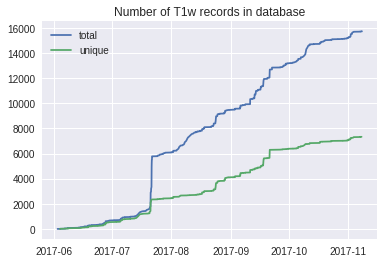

In [4]:
import datetime

import matplotlib.dates as mdates
from dateutil import parser

dates_t1w = [parser.parse(d) for d in df_t1w['_created'].values]
dates_t1w.sort()

dates_t1w_u = [parser.parse(d) for d in df_t1w_unique['_created'].values]
dates_t1w_u.sort()
# mindate = dates_t1w[0]
ax = plt.subplot(111)
ax.plot(dates_t1w, list(range(1, len(dates_t1w) + 1)), label='total')
ax.plot(dates_t1w_u, list(range(1, len(dates_t1w_u) + 1)), label='unique')
ax.set_title('Number of T1w records in database')
ax.legend()

plt.savefig('fig03a-0.svg', bbox_inches='tight', transparent=False, pad_inches=0)

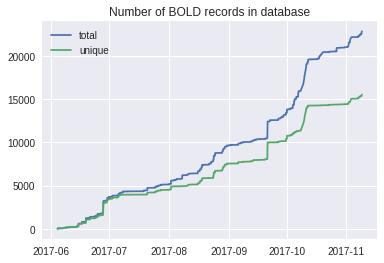

In [5]:
dates_bold = [parser.parse(d) for d in df_bold['_created'].values]
dates_bold.sort()
dates_bold_u = [parser.parse(d) for d in df_bold_unique['_created'].values]
dates_bold_u.sort()
# mindate = dates_t1w[0]
ax = plt.subplot(111)
ax.plot(dates_bold, list(range(1, len(dates_bold) + 1)), label='total')
ax.plot(dates_bold_u, list(range(1, len(dates_bold_u) + 1)), label='unique')
ax.set_title('Number of BOLD records in database')
ax.legend()
plt.savefig('fig03a-1.svg', bbox_inches='tight', transparent=False, pad_inches=0)

## Playing with T1w IQMs

Let's plot some of the IQMs for the T1w modality. First, let's check the names of the IQMs. These measures are explained in the documentation (http://mriqc.readthedocs.io/en/stable/iqms/t1w.html)

In [6]:
print(
    ','.join(
        [
            line
            for line in df_t1w.columns
            if not line.startswith('_')
            and not line.startswith('bids_meta')
            and not line.startswith('provenance')
        ]
    )
)

cjv,cnr,efc,fber,fwhm_avg,fwhm_x,fwhm_y,fwhm_z,icvs_csf,icvs_gm,icvs_wm,inu_med,inu_range,qi_1,qi_2,rpve_csf,rpve_gm,rpve_wm,size_x,size_y,size_z,snr_csf,snr_gm,snr_total,snr_wm,snrd_csf,snrd_gm,snrd_total,snrd_wm,spacing_x,spacing_y,spacing_z,summary_bg_k,summary_bg_mad,summary_bg_mean,summary_bg_median,summary_bg_n,summary_bg_p05,summary_bg_p95,summary_bg_stdv,summary_csf_k,summary_csf_mad,summary_csf_mean,summary_csf_median,summary_csf_n,summary_csf_p05,summary_csf_p95,summary_csf_stdv,summary_gm_k,summary_gm_mad,summary_gm_mean,summary_gm_median,summary_gm_n,summary_gm_p05,summary_gm_p95,summary_gm_stdv,summary_wm_k,summary_wm_mad,summary_wm_mean,summary_wm_median,summary_wm_n,summary_wm_p05,summary_wm_p95,summary_wm_stdv,tpm_overlap_csf,tpm_overlap_gm,tpm_overlap_wm,wm2max


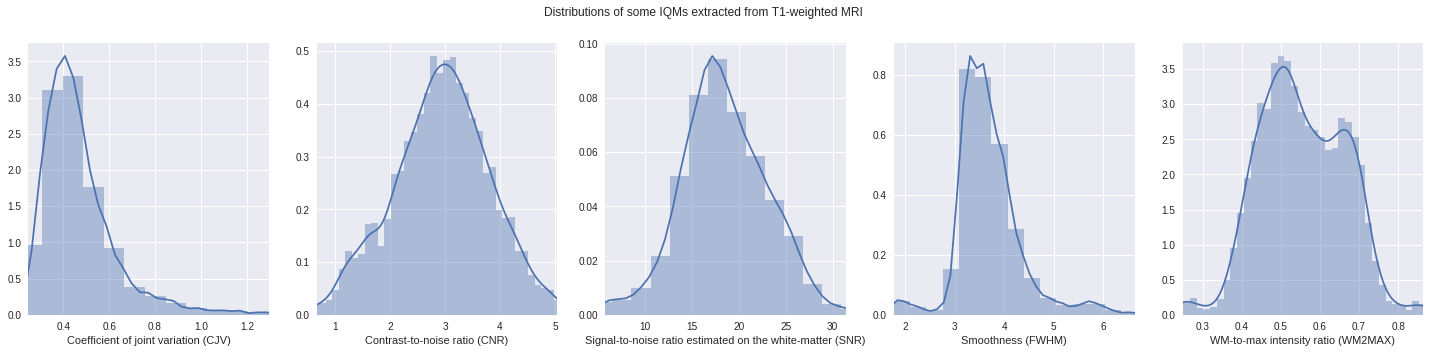

In [7]:
f, ax = plt.subplots(1, 5, figsize=(25, 5))
plot_measure(df_t1w_unique.cjv, xlabel='Coefficient of joint variation (CJV)', ax=ax[0])
plot_measure(df_t1w_unique.cnr, xlabel='Contrast-to-noise ratio (CNR)', ax=ax[1])
plot_measure(
    df_t1w_unique.snr_wm,
    xlabel='Signal-to-noise ratio estimated on the white-matter (SNR)',
    ax=ax[2],
)
plot_measure(df_t1w_unique.fwhm_avg, xlabel='Smoothness (FWHM)', ax=ax[3])
plot_measure(df_t1w_unique.wm2max, xlabel='WM-to-max intensity ratio (WM2MAX)', ax=ax[4])
plt.suptitle('Distributions of some IQMs extracted from T1-weighted MRI')
plt.savefig('fig03b-0.svg', bbox_inches='tight', transparent=False, pad_inches=0)

## Playing with BOLD IQMs

Let's plot some of the IQMs for the BOLD modality. First, let's check the names of the IQMs. These measures are explained in the documentation (http://mriqc.readthedocs.io/en/stable/iqms/bold.html)

In [8]:
print(
    ','.join(
        [
            line
            for line in df_bold.columns
            if not line.startswith('_')
            and not line.startswith('bids_meta')
            and not line.startswith('provenance')
        ]
    )
)

aor,aqi,dummy_trs,dvars_nstd,dvars_std,dvars_vstd,efc,fber,fd_mean,fd_num,fd_perc,fwhm_avg,fwhm_x,fwhm_y,fwhm_z,gcor,gsr_x,gsr_y,size_t,size_x,size_y,size_z,snr,spacing_tr,spacing_x,spacing_y,spacing_z,summary_bg_k,summary_bg_mad,summary_bg_mean,summary_bg_median,summary_bg_n,summary_bg_p05,summary_bg_p95,summary_bg_stdv,summary_fg_k,summary_fg_mad,summary_fg_mean,summary_fg_median,summary_fg_n,summary_fg_p05,summary_fg_p95,summary_fg_stdv,tsnr


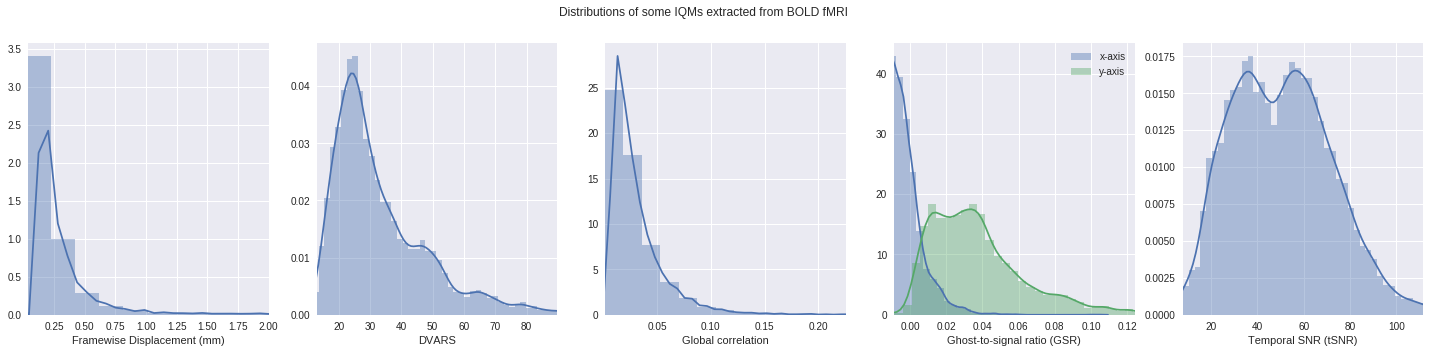

In [9]:
f, ax = plt.subplots(1, 5, figsize=(25, 5))
plot_measure(
    df_bold_unique[df_bold_unique.fd_mean < 10].fd_mean,
    xlabel='Framewise Displacement (mm)',
    max=2,
    ax=ax[0],
)
plot_measure(df_bold_unique[df_bold_unique.dvars_nstd < 100].dvars_nstd, xlabel='DVARS', ax=ax[1])
plot_measure(df_bold_unique.gcor, xlabel='Global correlation', ax=ax[2])
plot_measure(df_bold_unique.gsr_x, label='x-axis', ax=ax[3])
plot_measure(df_bold_unique.gsr_y, xlabel='Ghost-to-signal ratio (GSR)', label='y-axis', ax=ax[3])
ax[3].legend()
plot_measure(df_bold_unique.tsnr, xlabel='Temporal SNR (tSNR)', ax=ax[4])
plt.suptitle('Distributions of some IQMs extracted from BOLD fMRI')
plt.savefig(
    'fig03b-1.png', bbox_inches='tight', transparent=False, pad_inches=0, facecolor='white'
)